# Epic 4: Data analysis

`Als een key user kan ik voor een contact met weinig transacties een lookalike met veel transacties identificeren. Ik kan ook een clustering maken van contactpersonen die qua functie, bedrijfseigenschappen, gedrag en (verwacht) gedrag`

- Clustering (classification)
- Bij het geven van een contact, enkele lookalikes teruggeven gebaseerd op deze clustering

IN:
- Target contact
- Alle andere contacten

OUT: 
- X aantal dichtsbijzijnde contacten uit de lijst van alle andere contacten

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import dotenv
from sqlalchemy import create_engine, text

dotenv.load_dotenv()

True

In [2]:
# Start db
def create_conn():
    driver = os.getenv("DB_DRIVER")
    server = os.getenv("DB_SERVER")
    database = os.getenv("DB_NAME")
    trusted_connection = os.getenv("DB_TRUSTED_CONNECTION")

    return create_engine(
        f"mssql+pyodbc://{server}/{database}?trusted_connection={trusted_connection}&driver={driver}"
    )


engine = create_conn()
# Test connection
#connection = engine.connect()
#res = connection.execute(text("SELECT @@version;")).fetchone()
#connection.close()
#res[0]

In [3]:
SQL_LOCATION = "data/start_data.sql"
SAVE_LOCATION = os.getenv("EPIC_4_SAVE_LOCATION")
query = open(SQL_LOCATION, "r").read()

df = pd.read_sql(query, engine)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80270 entries, 0 to 80269
Data columns (total 29 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   crm_contact_functietitel                                   77794 non-null  object 
 1   crm_contact_voka_medewerker                                80270 non-null  object 
 2   crm_contact_id                                             80270 non-null  object 
 3   crm_functie_naam                                           80270 non-null  object 
 4   crm_persoon_mail_thema_duurzaamheid                        80270 non-null  object 
 5   crm_persoon_mail_thema_financieel_fiscaal                  80270 non-null  object 
 6   crm_persoon_mail_thema_innovatie                           80270 non-null  object 
 7   crm_persoon_mail_thema_internationaal_ondernemen           80270 non-null  object 
 8   crm_pe

In [4]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80255 entries, 0 to 80269
Data columns (total 29 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   crm_contact_functietitel                                   77780 non-null  object 
 1   crm_contact_voka_medewerker                                80255 non-null  object 
 2   crm_contact_id                                             80255 non-null  object 
 3   crm_functie_naam                                           80255 non-null  object 
 4   crm_persoon_mail_thema_duurzaamheid                        80255 non-null  object 
 5   crm_persoon_mail_thema_financieel_fiscaal                  80255 non-null  object 
 6   crm_persoon_mail_thema_innovatie                           80255 non-null  object 
 7   crm_persoon_mail_thema_internationaal_ondernemen           80255 non-null  object 
 8   crm_persoon

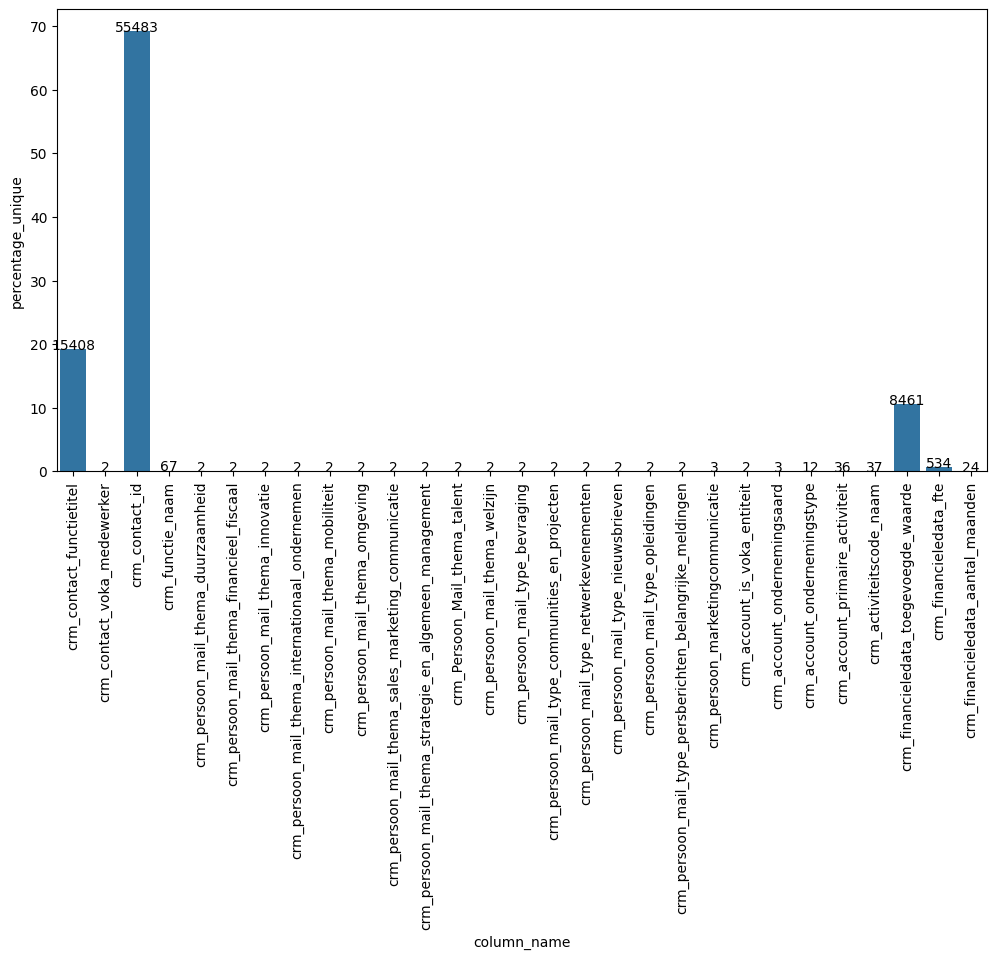

In [5]:
# Count the values

x_df_unique = pd.DataFrame(df.nunique()).reset_index()
x_df_unique.columns = ['column_name', 'unique_count']
# Add a column with the percentage of unique values
x_df_unique['percentage_unique'] = x_df_unique['unique_count'] / len(df) * 100
# Plot the information
plt.figure(figsize=(12, 6))
sns.barplot(x='column_name', y='percentage_unique', data=x_df_unique)
# Add the actual count of unique values on top of the bars
for i, row in x_df_unique.iterrows():
    plt.text(row.name, row.percentage_unique, row.unique_count, color='black', ha="center")
plt.xticks(rotation=90)
plt.show()

In [6]:
# Drop all single value columns
single_value_columns = x_df_unique[x_df_unique['unique_count'] == 1]['column_name'].tolist()
df.drop(single_value_columns, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80255 entries, 0 to 80269
Data columns (total 29 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   crm_contact_functietitel                                   77780 non-null  object 
 1   crm_contact_voka_medewerker                                80255 non-null  object 
 2   crm_contact_id                                             80255 non-null  object 
 3   crm_functie_naam                                           80255 non-null  object 
 4   crm_persoon_mail_thema_duurzaamheid                        80255 non-null  object 
 5   crm_persoon_mail_thema_financieel_fiscaal                  80255 non-null  object 
 6   crm_persoon_mail_thema_innovatie                           80255 non-null  object 
 7   crm_persoon_mail_thema_internationaal_ondernemen           80255 non-null  object 
 8   crm_persoon

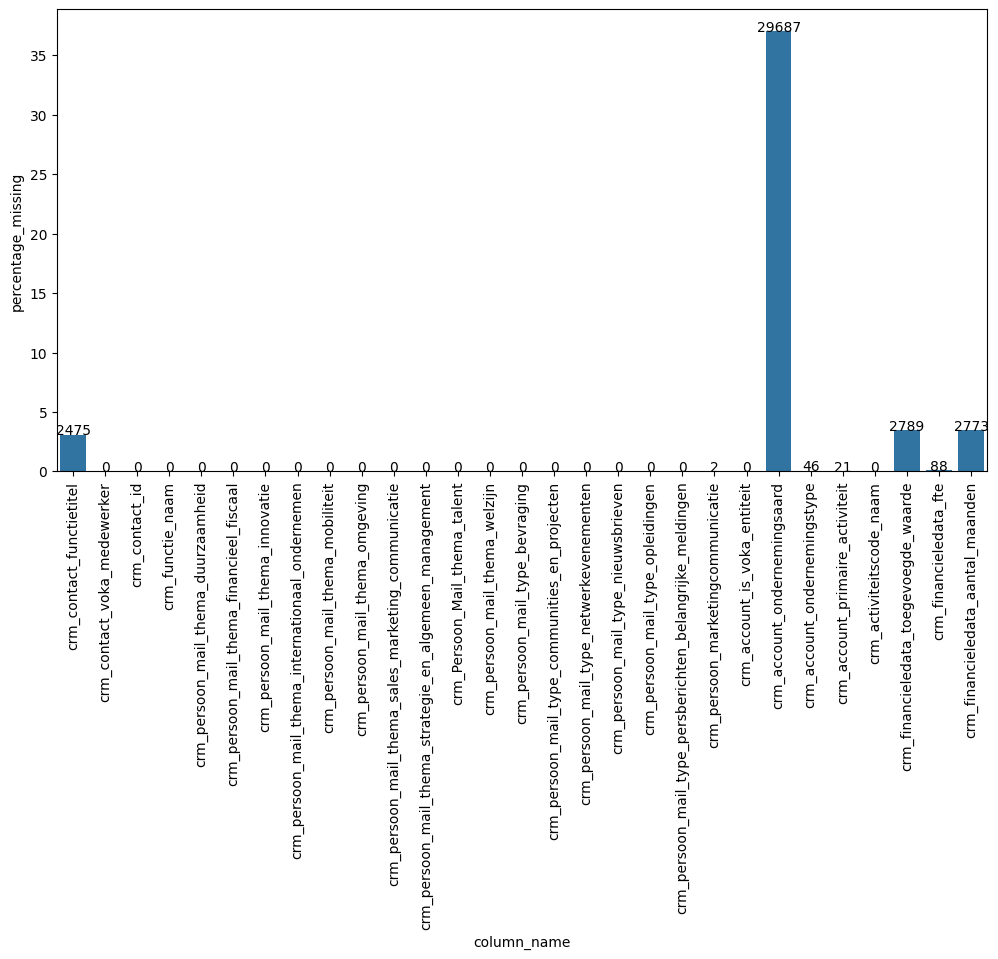

In [7]:
# Count the amount of missing values per column

x_df_missing = pd.DataFrame(df.isnull().sum()).reset_index()
x_df_missing.columns = ['column_name', 'missing_count']
# Add a column with the percentage of missing values
x_df_missing['percentage_missing'] = x_df_missing['missing_count'] / len(df) * 100
# Plot the information
plt.figure(figsize=(12, 6))
sns.barplot(x='column_name', y='percentage_missing', data=x_df_missing)
# Add the actual count of missing values on top of the bars
for i, row in x_df_missing.iterrows():
    plt.text(row.name, row.percentage_missing, row.missing_count, color='black', ha="center")

plt.xticks(rotation=90)
plt.show()

In [8]:
# Bring all of the columns to numeric values
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Get all of the columns that are not numeric
non_numeric_columns = df.select_dtypes(['object']).columns.tolist()
# Encode all of the columns that are not numeric
for column in non_numeric_columns:
    df[column] = le.fit_transform(df[column])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80255 entries, 0 to 80269
Data columns (total 29 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   crm_contact_functietitel                                   80255 non-null  int32  
 1   crm_contact_voka_medewerker                                80255 non-null  int32  
 2   crm_contact_id                                             80255 non-null  int32  
 3   crm_functie_naam                                           80255 non-null  int32  
 4   crm_persoon_mail_thema_duurzaamheid                        80255 non-null  int32  
 5   crm_persoon_mail_thema_financieel_fiscaal                  80255 non-null  int32  
 6   crm_persoon_mail_thema_innovatie                           80255 non-null  int32  
 7   crm_persoon_mail_thema_internationaal_ondernemen           80255 non-null  int32  
 8   crm_persoon

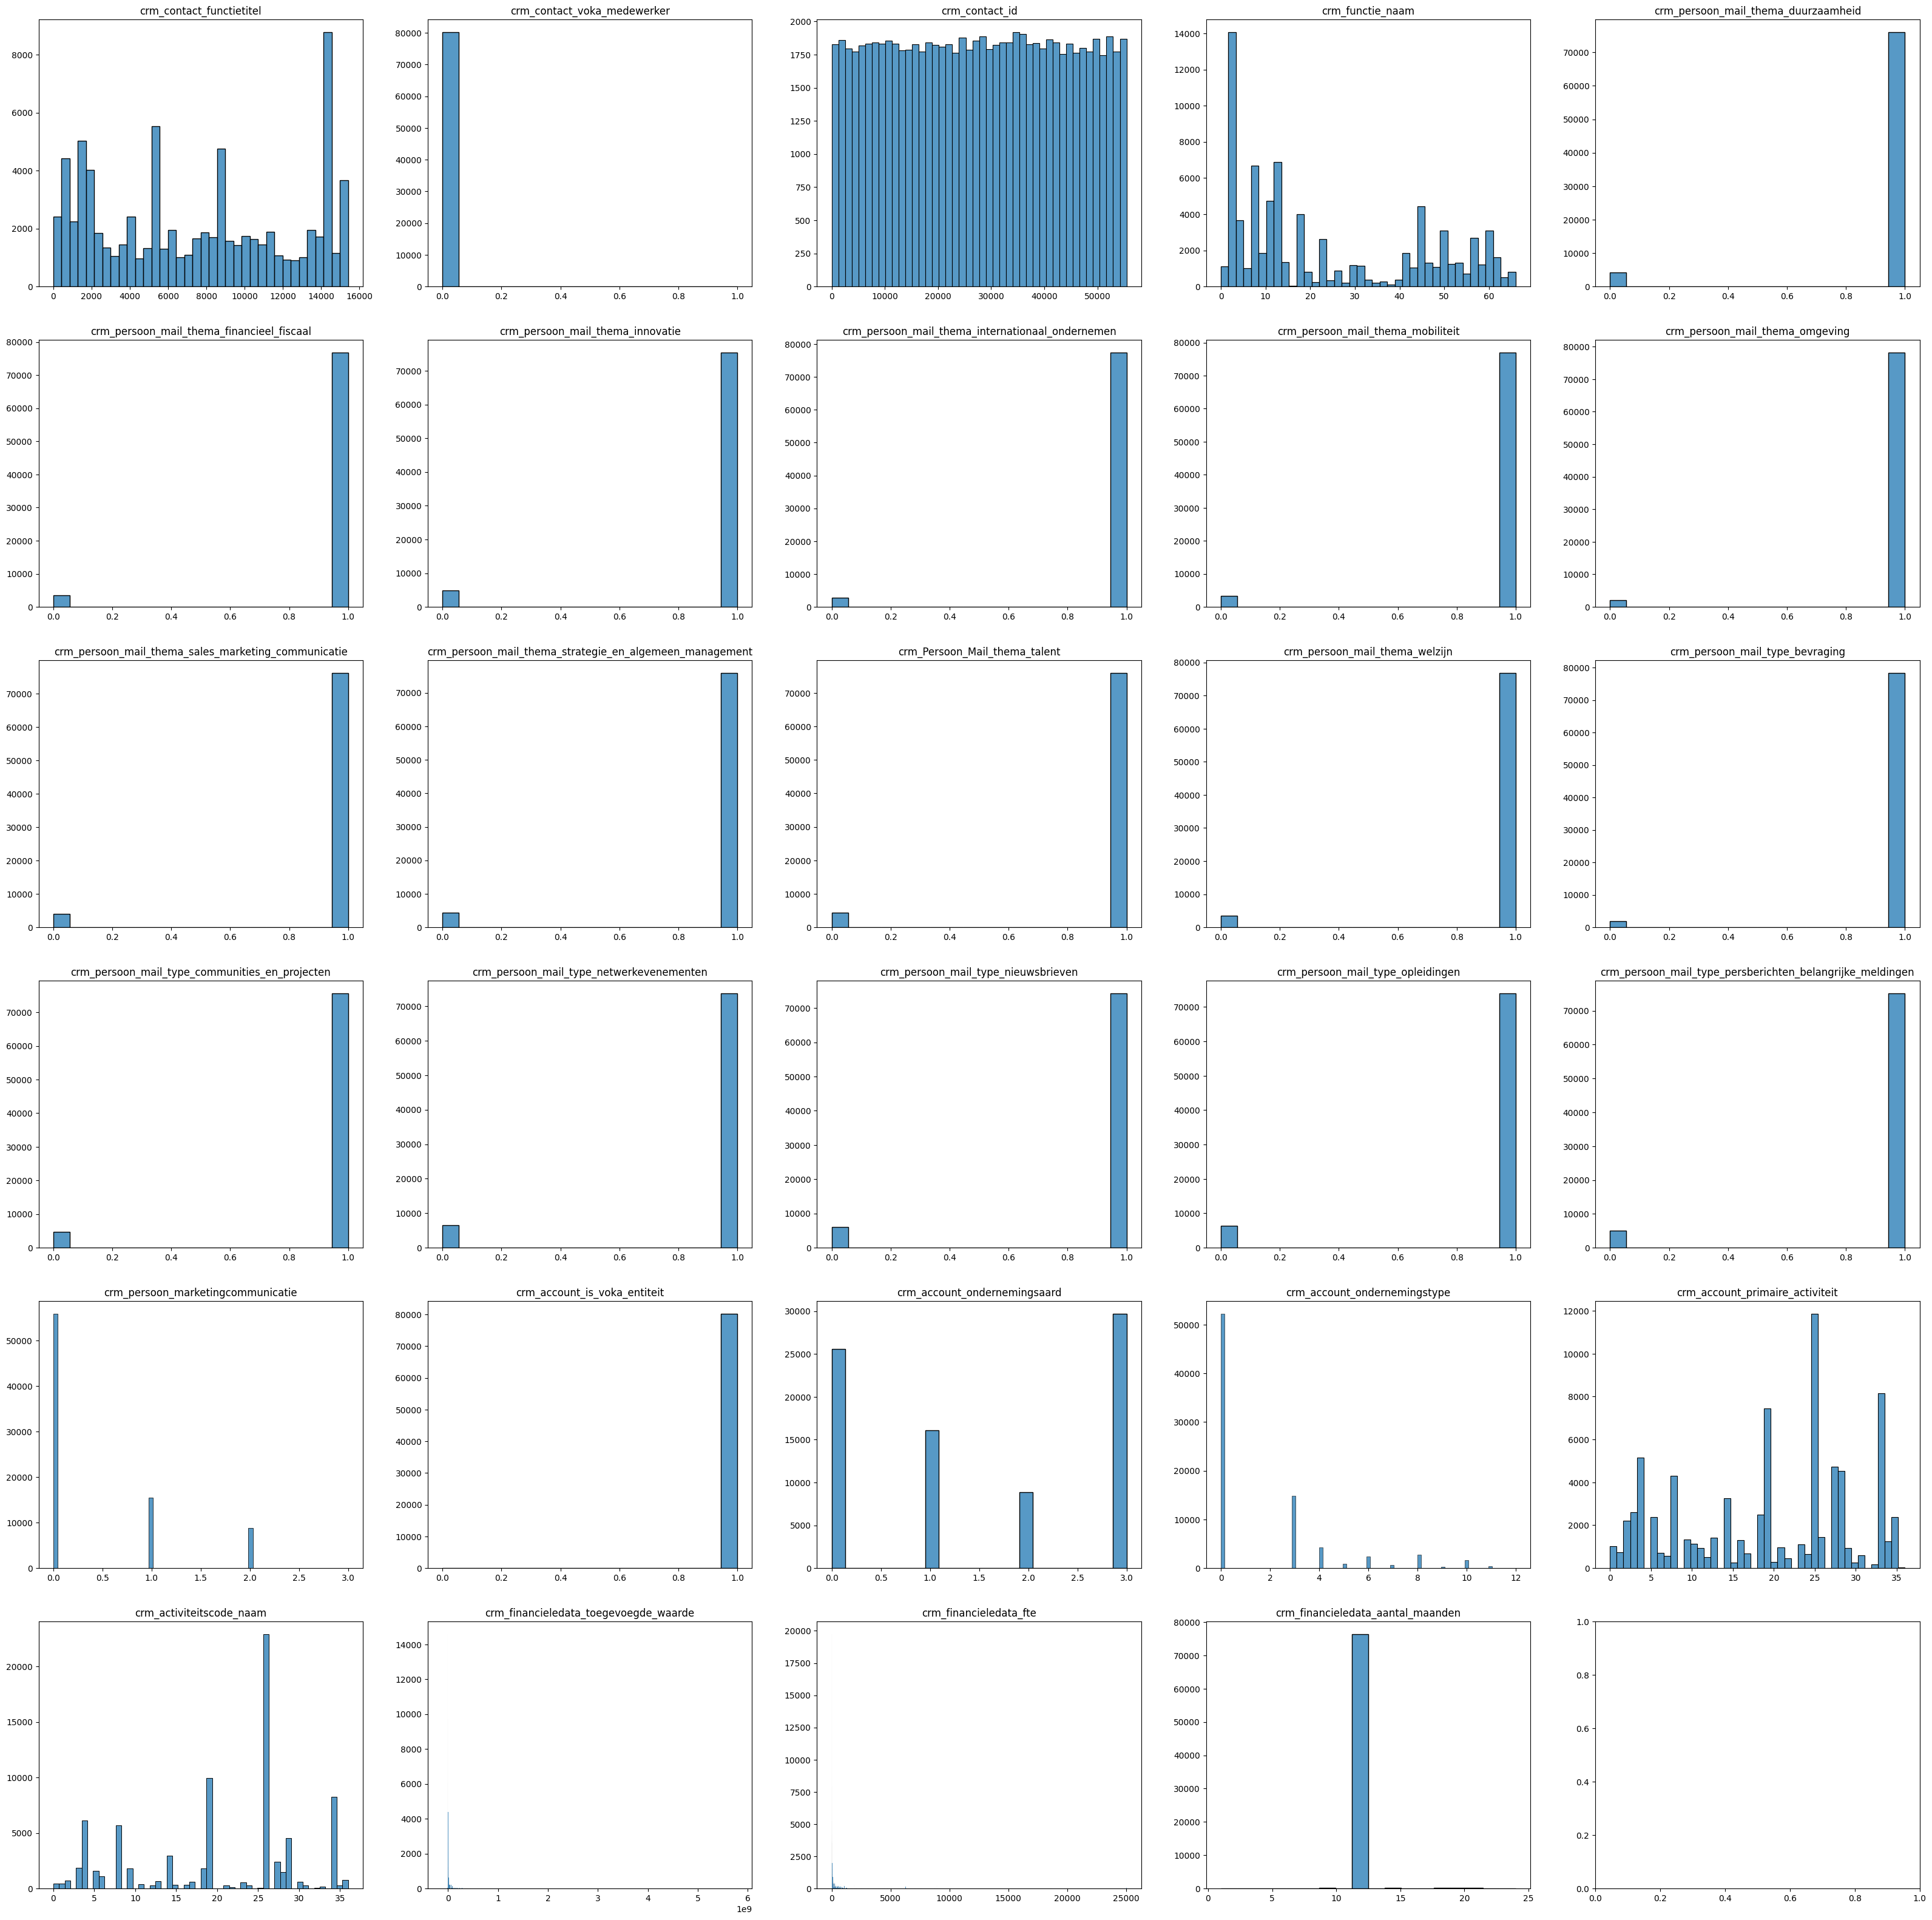

In [9]:
# Create a figure with subplots for each column
fig, axes = plt.subplots((len(df.columns) // 5) + 1, 5, figsize=(40, 40))

# Plot the distribution of each column
for i, column in enumerate(df.columns):
    sns.histplot(data=df, x=column, ax=axes[i // 5, i % 5])
    axes[i // 5, i % 5].set_title(column)
    axes[i // 5, i % 5].set_xlabel('')
    axes[i // 5, i % 5].set_ylabel('')

plt.show()

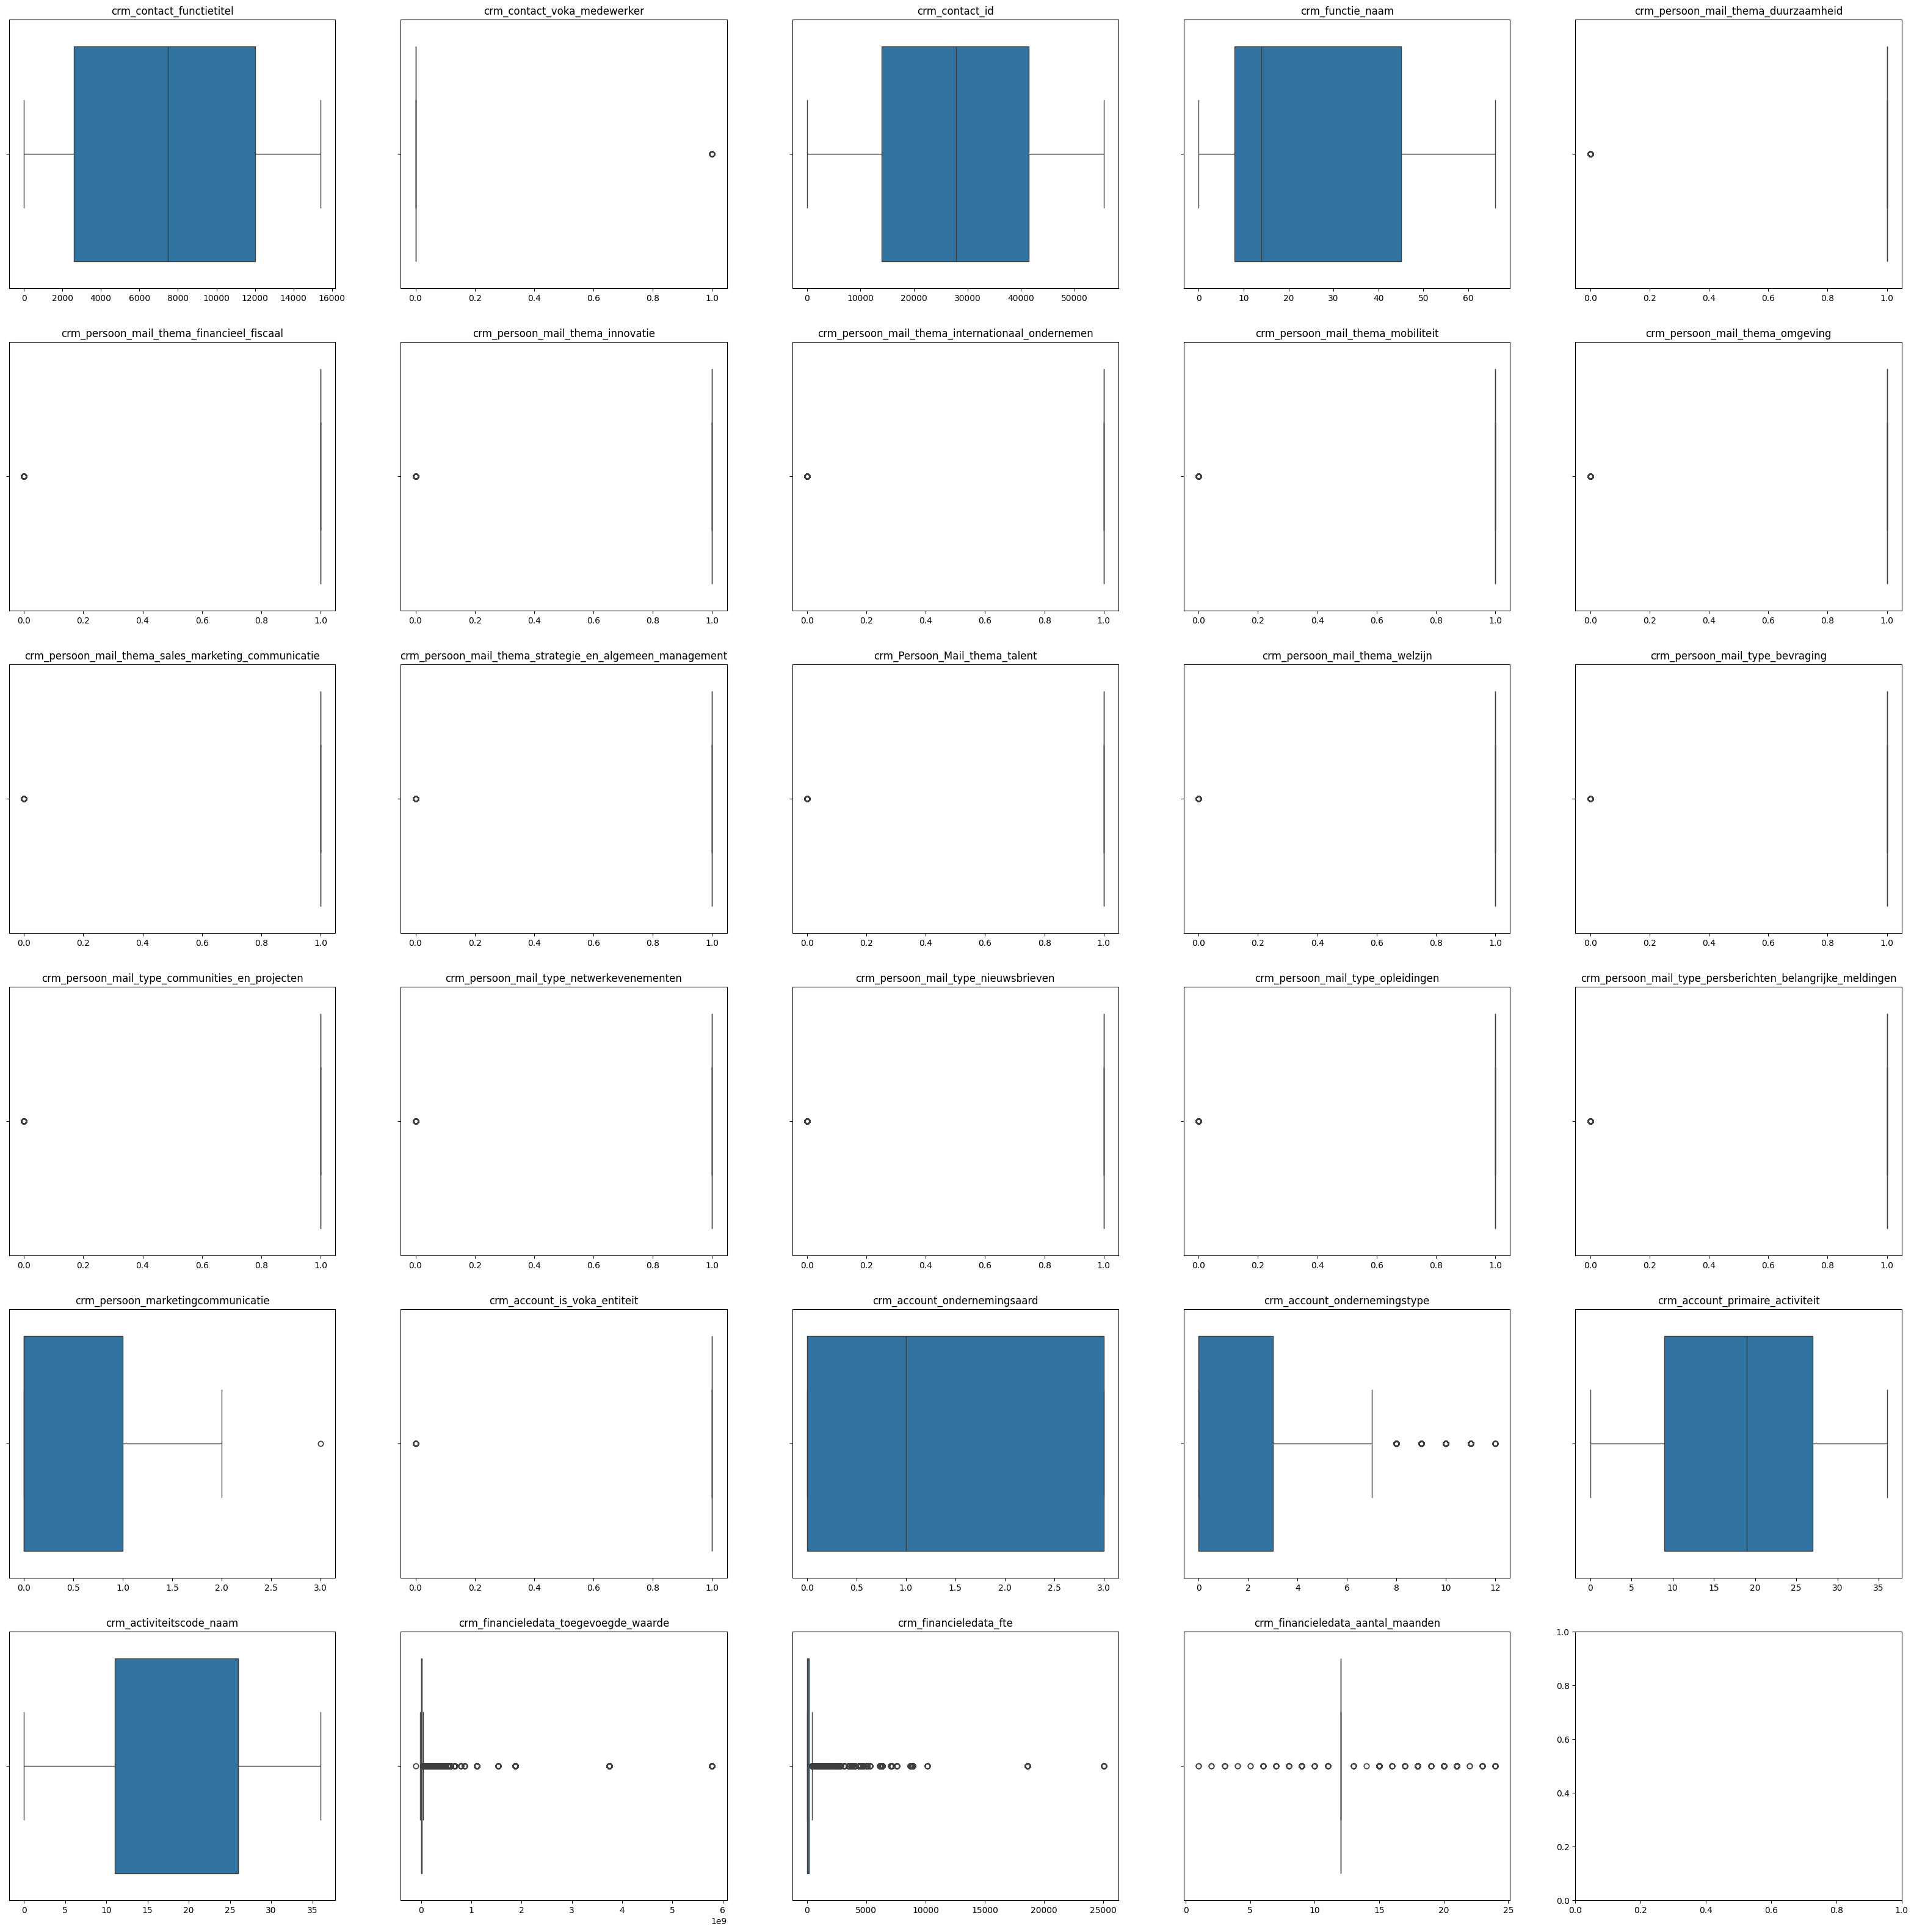

In [10]:
# Create a figure with subplots for each column
fig, axes = plt.subplots((len(df.columns) // 5) + 1, 5, figsize=(40, 40))

# Plot the Boxplot of each column

for i, column in enumerate(df.columns):
    sns.boxplot(data=df, x=column, ax=axes[i // 5, i % 5])
    axes[i // 5, i % 5].set_title(column)
    axes[i // 5, i % 5].set_xlabel('')
    axes[i // 5, i % 5].set_ylabel('')

plt.show()

# Heatmaps

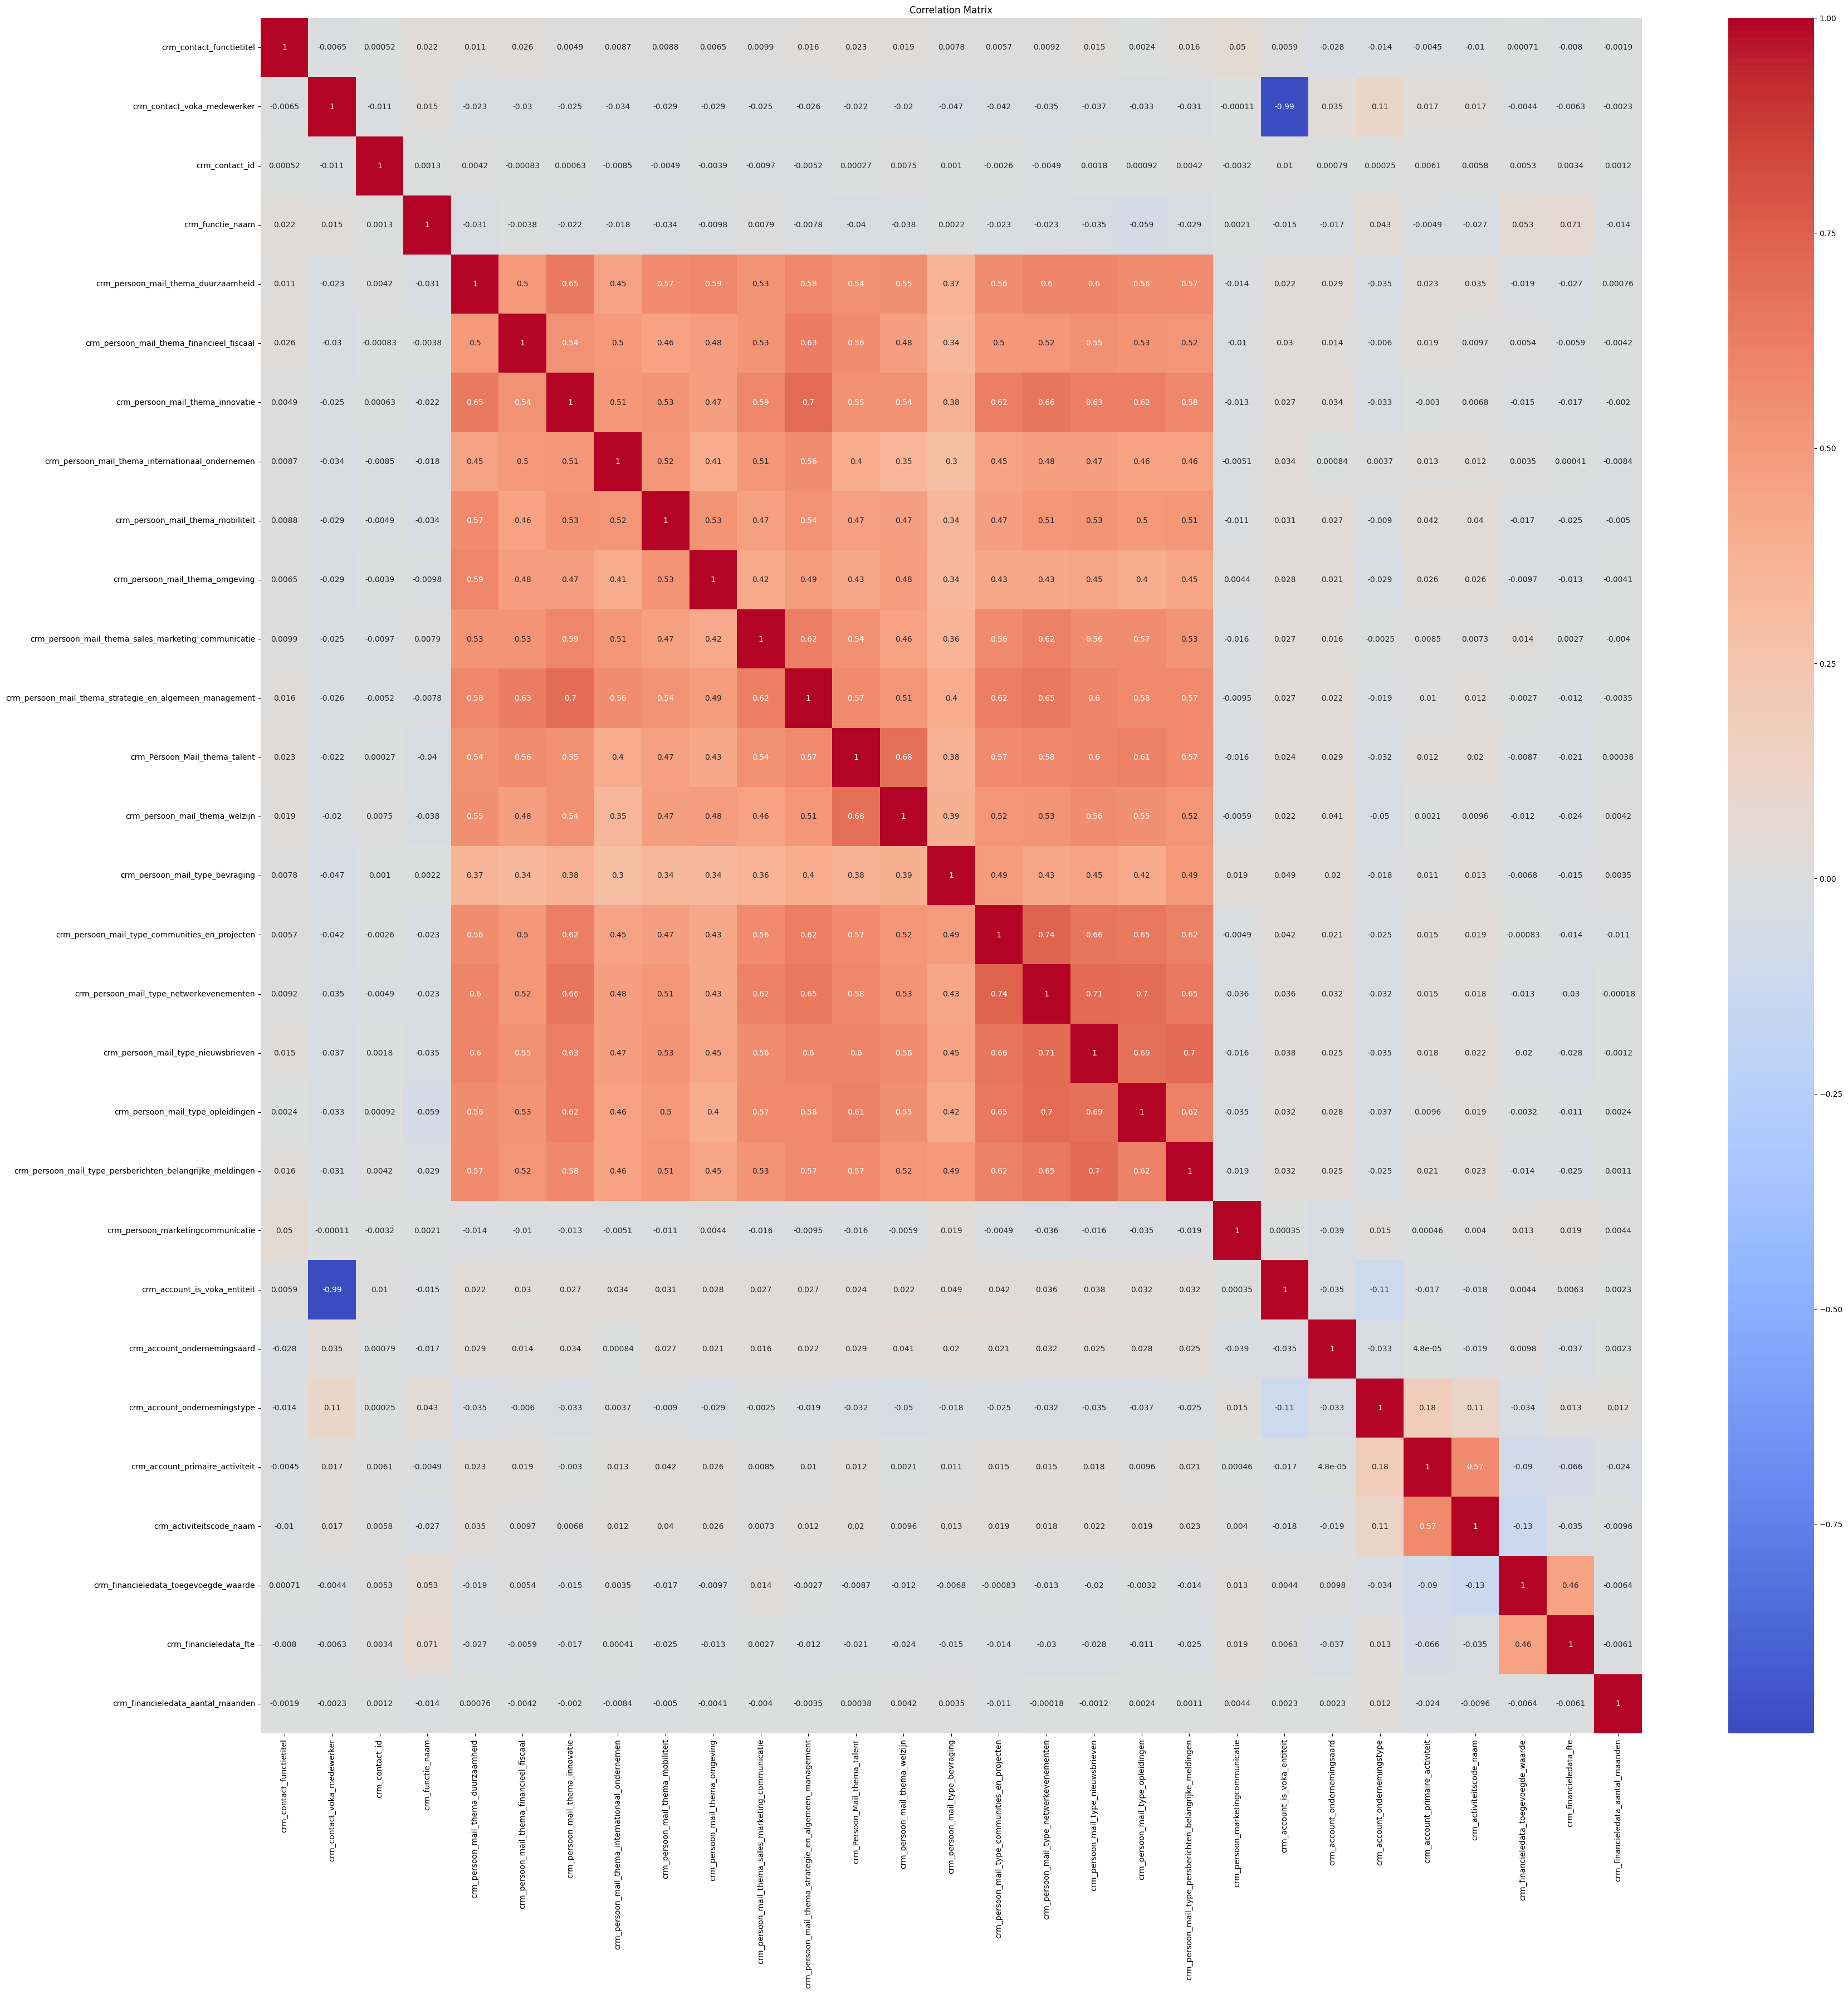

In [11]:
# Plot the a heatmap of the correlation of each column
fig, ax = plt.subplots(figsize=(40, 40))

sns.heatmap(df.corr(), annot=True, ax=ax, cmap='coolwarm')

ax.set_title('Correlation Matrix')
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

In [12]:
df.corr()


,crm_contact_functietitel,crm_contact_voka_medewerker,crm_contact_id,crm_functie_naam,crm_persoon_mail_thema_duurzaamheid,crm_persoon_mail_thema_financieel_fiscaal,crm_persoon_mail_thema_innovatie,crm_persoon_mail_thema_internationaal_ondernemen,crm_persoon_mail_thema_mobiliteit,crm_persoon_mail_thema_omgeving,...,crm_persoon_mail_type_persberichten_belangrijke_meldingen,crm_persoon_marketingcommunicatie,crm_account_is_voka_entiteit,crm_account_ondernemingsaard,crm_account_ondernemingstype,crm_account_primaire_activiteit,crm_activiteitscode_naam,crm_financieledata_toegevoegde_waarde,crm_financieledata_fte,crm_financieledata_aantal_maanden
crm_contact_functietitel,1.000000,-0.006538,0.000519,0.021603,0.011285,0.026024,0.004869,0.008669,0.008834,0.006539,...,0.016284,0.050421,0.005933,-0.027894,-0.014469,-0.004538,-0.010095,0.000705,-0.008040,-0.001921
crm_contact_voka_medewerker,-0.006538,1.000000,-0.010974,0.014989,-0.022530,-0.030256,-0.025181,-0.034403,-0.029231,-0.028760,...,-0.031005,-0.000105,-0.993214,0.034740,0.109200,0.017052,0.017396,-0.004408,-0.006254,-0.002251
crm_contact_id,0.000519,-0.010974,1.000000,0.001326,0.004191,-0.000832,0.000634,-0.008464,-0.004949,-0.003854,...,0.004165,-0.003169,0.010489,0.000789,0.000254,0.006139,0.005776,0.005333,0.003418,0.001173
crm_functie_naam,0.021603,0.014989,0.001326,1.000000,-0.030674,-0.003790,-0.022302,-0.018213,-0.034216,-0.009810,...,-0.028866,0.002111,-0.014584,-0.017234,0.043376,-0.004910,-0.026587,0.052611,0.071357,-0.014344
crm_persoon_mail_thema_duurzaamheid,0.011285,-0.022530,0.004191,-0.030674,1.000000,0.495031,0.646348,0.454960,0.571355,0.593559,...,0.570240,-0.014170,0.022281,0.028719,-0.035304,0.022994,0.034508,-0.018719,-0.026904,0.000757
crm_persoon_mail_thema_financieel_fiscaal,0.026024,-0.030256,-0.000832,-0.003790,0.495031,1.000000,0.535014,0.498566,0.457505,0.483127,...,0.523906,-0.010196,0.029964,0.014257,-0.006004,0.019097,0.009670,0.005420,-0.005888,-0.004228
crm_persoon_mail_thema_innovatie,0.004869,-0.025181,0.000634,-0.022302,0.646348,0.535014,1.000000,0.506034,0.532377,0.474641,...,0.583322,-0.013381,0.026624,0.034441,-0.033234,-0.002977,0.006800,-0.014992,-0.016843,-0.002002
crm_persoon_mail_thema_internationaal_ondernemen,0.008669,-0.034403,-0.008464,-0.018213,0.454960,0.498566,0.506034,1.000000,0.519925,0.407234,...,0.459269,-0.005107,0.034092,0.000844,0.003686,0.013293,0.012080,0.003544,0.000411,-0.008403
crm_persoon_mail_thema_mobiliteit,0.008834,-0.029231,-0.004949,-0.034216,0.571355,0.457505,0.532377,0.519925,1.000000,0.530987,...,0.512479,-0.011302,0.031020,0.027062,-0.008993,0.042385,0.039718,-0.016630,-0.024676,-0.004964
crm_persoon_mail_thema_omgeving,0.006539,-0.028760,-0.003854,-0.009810,0.593559,0.483127,0.474641,0.407234,0.530987,1.000000,...,0.446947,0.004359,0.028498,0.021325,-0.029271,0.026322,0.025807,-0.009750,-0.012933,-0.004110


### Imputer


In [13]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Create or load your DataFrame (df) first

# Create an instance of SimpleImputer with the desired strategy (e.g., 'mean', 'median', 'most_frequent', or a constant value)
imputer = SimpleImputer(strategy='median')  # Replace NaN with the mean of each column

# Fit the imputer on your data (compute the mean, median, or most frequent values for each column)
imputer.fit(df)

# Transform the DataFrame by replacing NaN values with the computed values
df_imputed = imputer.transform(df)

# The result is a NumPy array, so you can convert it back to a DataFrame if needed
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

## Determine amount clusters

### first with all features

#### best = 2


In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test K values from 2 to some maximum number of clusters
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_imputed)  # Use your data here
    silhouette_avg = silhouette_score(df_imputed, labels)
    print(f"For n_clusters = {k}, the average silhouette score is {silhouette_avg}")


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2, the average silhouette score is 0.9866781268263346


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3, the average silhouette score is 0.9545303185502018


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4, the average silhouette score is 0.9647354400681704


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5, the average silhouette score is 0.9014406714266905


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6, the average silhouette score is 0.8297312406872486


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7, the average silhouette score is 0.823886362957571


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8, the average silhouette score is 0.7982414557159319


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9, the average silhouette score is 0.7986424118665941


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10, the average silhouette score is 0.7904139029974389


### testing with select features

In [15]:
# Silhouette score for a few features

# Assuming you have a DataFrame 'data' with multiple features
# Select the features you want to include in the Silhouette Score calculation
selected_features = df_imputed[['crm_contact_functietitel', 'crm_functie_naam', 'crm_account_ondernemingsaard','crm_account_ondernemingstype','crm_account_primaire_activiteit']]

# Choose the number of clusters (k) for your KMeans clustering
# Test K values from 2 to some maximum number of clusters
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(selected_features)  # Use your data here
    silhouette_avg = silhouette_score(selected_features, labels)
    print(f"For n_clusters = {k}, the average silhouette score is {silhouette_avg}")

c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2, the average silhouette score is 0.649711153893779


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3, the average silhouette score is 0.6463706128652789


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4, the average silhouette score is 0.6712331385420436


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5, the average silhouette score is 0.6671700754567756


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6, the average silhouette score is 0.6449972301091478


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7, the average silhouette score is 0.6244224892797624


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8, the average silhouette score is 0.6032588066347754


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9, the average silhouette score is 0.6054989566166953


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10, the average silhouette score is 0.6097551078145743


### k-means toepassen


In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Stap 2: Feature Selectie
selected_features = df_imputed[['crm_account_ondernemingsaard', 'crm_account_ondernemingstype']]

# Stap 3: Normalisatie
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

# Stap 4: Kies een Clusteringalgoritme en 5: Bepaal het Aantal Clusters
#n_clusters = 4  # Aantal clusters dat je wilt creëren
kmeans = KMeans()

# Stap 6: Clustering Uitvoeren
kmeans.fit(df_imputed)

# Voeg de toegewezen clusterlabels toe aan je oorspronkelijke dataset
#data['cluster'] = kmeans.labels_

cluster_labels = kmeans.labels_


c:\Users\Maarten Boon\Documents\school\jaar3\DEP II\code\Data-Engineering-Project-II\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### print result

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


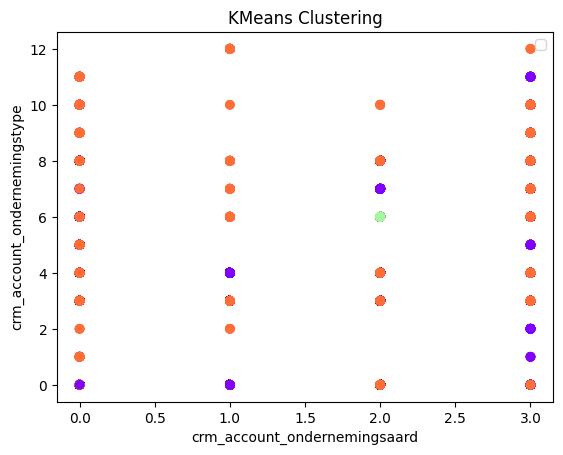

In [17]:
import matplotlib.pyplot as plt

# Assuming you have performed KMeans clustering and have cluster labels in 'cluster_labels'

# Create a scatter plot for two of your feature columns (e.g., 'feature1' and 'feature2')
plt.scatter(df_imputed['crm_account_ondernemingsaard'], df_imputed['crm_account_ondernemingstype'], c=cluster_labels, cmap='rainbow')

# Add labels and a legend
plt.xlabel('crm_account_ondernemingsaard')
plt.ylabel('crm_account_ondernemingstype')
plt.title('KMeans Clustering')
plt.legend()

# Show the plot
plt.show()